In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Datasets

In [2]:
empathy_messages_df = pd.read_csv('data/responses/data/messages.csv')
print(empathy_messages_df.shape)
empathy_messages_df.head()

(1860, 8)


,message_id,response_id,article_id,empathy,distress,empathy_bin,distress_bin,essay
0,R_1hGrPtWM4SumG0U_1,R_1hGrPtWM4SumG0U,67,5.667,4.375,1,1,it is really diheartening to read about these ...
1,R_1hGrPtWM4SumG0U_2,R_1hGrPtWM4SumG0U,86,4.833,4.875,1,1,the phone lines from the suicide prevention li...
2,R_1hGrPtWM4SumG0U_3,R_1hGrPtWM4SumG0U,206,5.333,3.500,1,0,"no matter what your heritage, you should be ab..."
3,R_1hGrPtWM4SumG0U_4,R_1hGrPtWM4SumG0U,290,4.167,5.250,1,1,it is frightening to learn about all these sha...
4,R_1hGrPtWM4SumG0U_5,R_1hGrPtWM4SumG0U,342,5.333,4.625,1,1,the eldest generation of russians aren't being...


In [3]:
# regression_empathy_df = pd.read_csv('lexica/regression_weights/dd_EmpathyLex.csv', index_col=0)

In [4]:
# mixed_ffn_empathy_df = pd.read_csv('lexica/mixed_level_ffn/empathy_ratings.tsv', sep='\t', index_col=0)

# Distributions

In [5]:
xlabel='Ratings'
ylabel='Counts'
bins=None

### Empathy

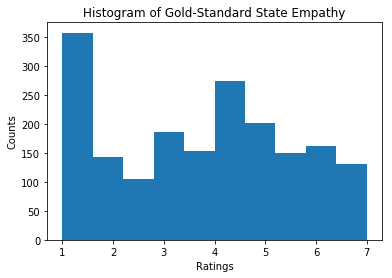

In [6]:
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Histogram of Gold-Standard State Empathy')
plt.hist(empathy_messages_df['empathy'], bins=bins);

### Distress

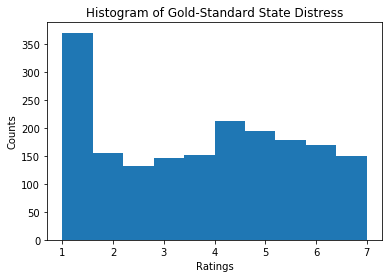

In [7]:
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Histogram of Gold-Standard State Distress')
plt.hist(empathy_messages_df['distress'], bins=bins);

# Correlation

In [8]:
from scipy import stats as st

def correlation(true, pred):
    result=st.pearsonr(true,pred)
    return result

correlations={}
group_key = 'message_id'
weight_key = 'group_norm'
top_N = 'false'
N = 20

In [9]:
empathy_id_to_test_fold_df = pd.read_csv('modeling/main/crossvalidation/results/empathy_id_to_test_fold.tsv', sep='\t', index_col=0)
print(empathy_id_to_test_fold_df.shape)
empathy_id_to_test_fold_df.head()

(1674, 2)


,id,test_fold
0,R_3rPu02mAYdW61Xg_2,0
1,R_3kp1NhG01T0k5mf_3,0
2,R_1FPPdbnLwSGuNfD_2,0
3,R_1eVIE8HYgaJnhyF_5,0
4,R_2Ua8QrptM9JbrQW_5,0


In [10]:
from nltk.tokenize import wordpunct_tokenize as tokenize
from collections import Counter

In [11]:
results = {}
results_key = 'mean_binary'
correlations_key = 'Mean Binary Rating'

for emo in ['empathy', 'distress']:
    predict_key = f'avg(empathy.{emo}_bin)'
    results[emo] = []
    p_values = []
    
    for i in range(10):
        test_message_fold_df = empathy_id_to_test_fold_df[empathy_id_to_test_fold_df['test_fold']==i]
        test_messages_df = empathy_messages_df.merge(test_message_fold_df, left_on='message_id', right_on='id')
        
        empathy_1grams = []
        for _, row in test_messages_df.iterrows():
            tokens = tokenize(row['essay'])
            c = Counter(tokens)
            c_sum = sum(c.values())
            for token, count in c.items():
                token_dict = {group_key: row[group_key], 'feat': token, 'value': count, 'group_norm': count/c_sum}
                empathy_1grams.append(token_dict)
                
        empathy_1grams_df = pd.DataFrame.from_dict(empathy_1grams)
        
        mean_ratings_df = pd.read_csv(f'lexica/mean_ratings/empathy_ratings_{i}.csv')
        merge_df = empathy_1grams_df.merge(mean_ratings_df, left_on='feat', right_on='feat', suffixes=('', '_2'))

        working_df = merge_df
        working_df['weighted_prediction'] = working_df[weight_key]*working_df[predict_key]

        if top_N:
            # Find top/bottom N predictions for empathy and top N predictions for distress.
            sorted_df = working_df.groupby('feat').max().sort_values(predict_key, ascending=False)
            top_feats = sorted_df.index

            drop_indices = list(range(N, len(sorted_df)-N)) if emo == 'empathy' else list(range(N, len(sorted_df)))
            top_feats = top_feats.drop(top_feats[drop_indices])
            filtered_df = working_df[working_df['feat'].isin(top_feats)]
            working_df = filtered_df

        # Correlate the weighted sum of predictions for the top/bottom features with user-level ratings.
        grouped_df = working_df.groupby(group_key).sum()
        grouped_df = grouped_df.reset_index()
        
        final_df = grouped_df.merge(empathy_messages_df)
        result, two_tailed_p_value = correlation(final_df[emo], final_df['weighted_prediction'])
        results[emo].append(result)
        p_values.append(two_tailed_p_value)
    
    results[emo] = np.mean(results[emo])
    print(f'{correlations_key} average 2-tailed p-value for {emo}: {np.mean(p_values)}')

correlations[correlations_key] = results

Mean Binary Rating average 2-tailed p-value for empathy: 0.6164351986256371
Mean Binary Rating average 2-tailed p-value for distress: 0.583025167002748


In [12]:
results = {}
results_key = 'mean_star'
correlations_key = 'Mean Star Rating'

for emo in ['empathy', 'distress']:
    predict_key = f'avg(empathy.{emo})'
    results[emo] = []
    p_values = []
    
    for i in range(10):
        test_message_fold_df = empathy_id_to_test_fold_df[empathy_id_to_test_fold_df['test_fold']==i]
        test_messages_df = empathy_messages_df.merge(test_message_fold_df, left_on='message_id', right_on='id')
        
        empathy_1grams = []
        for _, row in test_messages_df.iterrows():
            tokens = tokenize(row['essay'])
            c = Counter(tokens)
            c_sum = sum(c.values())
            for token, count in c.items():
                token_dict = {group_key: row[group_key], 'feat': token, 'value': count, 'group_norm': count/c_sum}
                empathy_1grams.append(token_dict)
                
        empathy_1grams_df = pd.DataFrame.from_dict(empathy_1grams)
        
        mean_ratings_df = pd.read_csv(f'lexica/mean_ratings/empathy_ratings_{i}.csv')
        merge_df = empathy_1grams_df.merge(mean_ratings_df, left_on='feat', right_on='feat', suffixes=('', '_2'))

        working_df = merge_df
        working_df['weighted_prediction'] = working_df[weight_key]*working_df[predict_key]

        if top_N:
            # Find top/bottom N predictions for empathy and top N predictions for distress.
            sorted_df = working_df.groupby('feat').max().sort_values(predict_key, ascending=False)
            top_feats = sorted_df.index

            drop_indices = list(range(N, len(sorted_df)-N)) if emo == 'empathy' else list(range(N, len(sorted_df)))
            top_feats = top_feats.drop(top_feats[drop_indices])
            filtered_df = working_df[working_df['feat'].isin(top_feats)]
            working_df = filtered_df

        # Correlate the weighted sum of predictions for the top/bottom features with user-level ratings.
        grouped_df = working_df.groupby(group_key).sum()
        grouped_df = grouped_df.reset_index()
        
        final_df = grouped_df.merge(empathy_messages_df)
        result, two_tailed_p_value = correlation(final_df[emo], final_df['weighted_prediction'])
        results[emo].append(result)
        p_values.append(two_tailed_p_value)
    
    results[emo] = np.mean(results[emo])
    print(f'{correlations_key} average 2-tailed p-value for {emo}: {np.mean(p_values)}')

correlations[correlations_key] = results

Mean Star Rating average 2-tailed p-value for empathy: 0.45134337807433444
Mean Star Rating average 2-tailed p-value for distress: 0.8035187466158679


In [13]:
results = {}
results_key = 'regression_weights'
correlations_key = 'Regression Weights'

for emo in ['empathy', 'distress']:
    predict_key = f'weight'
    results[emo] = []
    p_values = []
    
    for i in range(10):
        test_message_fold_df = empathy_id_to_test_fold_df[empathy_id_to_test_fold_df['test_fold']==i]
        test_messages_df = empathy_messages_df.merge(test_message_fold_df, left_on='message_id', right_on='id')
        
        empathy_1grams = []
        for _, row in test_messages_df.iterrows():
            tokens = tokenize(row['essay'])
            c = Counter(tokens)
            c_sum = sum(c.values())
            for token, count in c.items():
                token_dict = {group_key: row[group_key], 'feat': token, 'value': count, 'group_norm': count/c_sum}
                empathy_1grams.append(token_dict)
                
        empathy_1grams_df = pd.DataFrame.from_dict(empathy_1grams)
        
        regression_weights_df = pd.read_csv(f'lexica/regression_weights/dd_{emo.capitalize()}Lex{i}.csv')
        merge_df = empathy_1grams_df.merge(regression_weights_df, left_on='feat', right_on='term', suffixes=('', '_2'))

        working_df = merge_df
        working_df['weighted_prediction'] = working_df[weight_key]*working_df[predict_key]

        if top_N:
            # Find top/bottom N predictions for empathy and top N predictions for distress.
            sorted_df = working_df.groupby('feat').max().sort_values(predict_key, ascending=False)
            top_feats = sorted_df.index

            drop_indices = list(range(N, len(sorted_df)-N)) if emo == 'empathy' else list(range(N, len(sorted_df)))
            top_feats = top_feats.drop(top_feats[drop_indices])
            filtered_df = working_df[working_df['feat'].isin(top_feats)]
            working_df = filtered_df

        # Correlate the weighted sum of predictions for the top/bottom features with user-level ratings.
        grouped_df = working_df.groupby(group_key).sum()
        grouped_df = grouped_df.reset_index()
        
        final_df = grouped_df.merge(empathy_messages_df)
        result, two_tailed_p_value = correlation(final_df[emo], final_df['weighted_prediction'])
        results[emo].append(result)
        p_values.append(two_tailed_p_value)
    
    results[emo] = np.mean(results[emo])
    print(f'{correlations_key} average 2-tailed p-value for {emo}: {np.mean(p_values)}')

correlations[correlations_key] = results

Regression Weights average 2-tailed p-value for empathy: 0.09837546298426234
Regression Weights average 2-tailed p-value for distress: 0.30095551949991206


In [14]:
results = {}
results_key = 'mixed_level_ffn'
correlations_key = 'Mixed-Level FFN'

for emo in ['empathy', 'distress']:
    predict_key = f'ratings'
    results[emo] = []
    p_values = []
    
    for i in range(10):
        test_message_fold_df = empathy_id_to_test_fold_df[empathy_id_to_test_fold_df['test_fold']==i]
        test_messages_df = empathy_messages_df.merge(test_message_fold_df, left_on='message_id', right_on='id')
        
        empathy_1grams = []
        for _, row in test_messages_df.iterrows():
            tokens = tokenize(row['essay'])
            c = Counter(tokens)
            c_sum = sum(c.values())
            for token, count in c.items():
                token_dict = {group_key: row[group_key], 'feat': token, 'value': count, 'group_norm': count/c_sum}
                empathy_1grams.append(token_dict)
                
        empathy_1grams_df = pd.DataFrame.from_dict(empathy_1grams)
        
        mixed_ffn_df = pd.read_csv(f'modeling/main/crossvalidation/results/distress_ratings_{i}.tsv', sep='\t')
        merge_df = empathy_1grams_df.merge(mixed_ffn_df, left_on='feat', right_on='tokens', suffixes=('', '_2'))

        working_df = merge_df
        working_df['weighted_prediction'] = working_df[weight_key]*working_df[predict_key]

        if top_N:
            # Find top/bottom N predictions for empathy and top N predictions for distress.
            sorted_df = working_df.groupby('feat').max().sort_values(predict_key, ascending=False)
            top_feats = sorted_df.index

            drop_indices = list(range(N, len(sorted_df)-N)) if emo == 'empathy' else list(range(N, len(sorted_df)))
            top_feats = top_feats.drop(top_feats[drop_indices])
            filtered_df = working_df[working_df['feat'].isin(top_feats)]
            working_df = filtered_df

        # Correlate the weighted sum of predictions for the top/bottom features with user-level ratings.
        grouped_df = working_df.groupby(group_key).sum()
        grouped_df = grouped_df.reset_index()
        
        final_df = grouped_df.merge(empathy_messages_df)
        result, two_tailed_p_value = correlation(final_df[emo], final_df['weighted_prediction'])
        results[emo].append(result)
        p_values.append(two_tailed_p_value)
    
    results[emo] = np.mean(results[emo])
    print(f'{correlations_key} average 2-tailed p-value for {emo}: {np.mean(p_values)}')

correlations[correlations_key] = results

Mixed-Level FFN average 2-tailed p-value for empathy: 0.2763456185772735
Mixed-Level FFN average 2-tailed p-value for distress: 0.5209554558166083


In [15]:
correlations_df = pd.DataFrame(correlations).transpose()
correlations_df = correlations_df[['empathy', 'distress']]
correlations_df = correlations_df.rename(index=str, columns={"empathy": "Empathy", "distress": "Distress"})
correlations_df['Mean'] = correlations_df.mean(axis=1)
correlations_df = correlations_df.sort_values('Mean')
correlations_df

,Empathy,Distress,Mean
Mean Binary Rating,0.052866,-0.007385,0.022741
Mixed-Level FFN,0.165525,-0.051921,0.056802
Mean Star Rating,0.134575,-0.008075,0.063250
Regression Weights,0.156625,0.102676,0.129651
